In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification, ViTFeatureExtractor
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report
import os
from sklearn.preprocessing import LabelEncoder
import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random


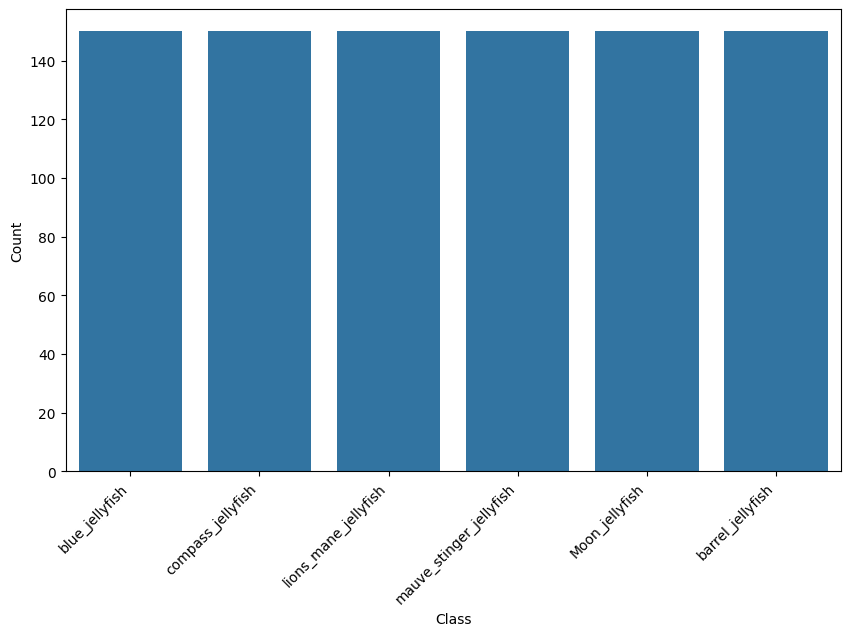

In [18]:
def load_data(data_directory):
    images = []
    labels = []
    classes = []
    label_encoder = LabelEncoder()

    for class_name in os.listdir(data_directory):
        class_path = os.path.join(data_directory, class_name)
        classes.append(class_name)

        for filename in os.listdir(class_path):
            filepath = os.path.join(class_path, filename)
            img = cv2.imread(filepath)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                img = cv2.resize(img, (224, 224))
                img = img / 255.0
                images.append(img)
                labels.append(class_name)

    images = np.array(images)
    labels = label_encoder.fit_transform(labels) 

    return images, labels, classes

# Update the path to your dataset
data_directory = './jellyfish_data'
images, labels, classes = load_data(data_directory)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.countplot(x=[classes[label] for label in labels])  
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
classes = np.unique(classes)

In [23]:
# 이미지 증강
transform_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [24]:
# PyTorch TensorDataset으로 변환
train_data = [(transform_train(X_train[i]), y_train[i]) for i in range(len(X_train))]
test_data = [(transform_test(X_test[i]), y_test[i]) for i in range(len(X_test))]

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

print("Classes:", classes)

Classes: ['Moon_jellyfish' 'barrel_jellyfish' 'blue_jellyfish' 'compass_jellyfish'
 'lions_mane_jellyfish' 'mauve_stinger_jellyfish']


In [25]:
# 2. ViT 모델 정의 및 초기화
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=len(classes),
    ignore_mismatched_sizes=True  # 가중치 크기 불일치 무시
)
model = model.to(device)


# 3. 손실 함수 및 옵티마이저 설정
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

# 4. 학습 및 검증 루프
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images = images.to(device)
        labels = torch.tensor(labels, dtype=torch.long).to(device)

        # Forward
        outputs = model(images).logits
        loss = criterion(outputs, labels)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    accuracy = correct / total
    return total_loss / len(dataloader), accuracy

def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = torch.tensor(labels, dtype=torch.long).to(device)

            outputs = model(images).logits
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return total_loss / len(dataloader), accuracy

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([6]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
# 5. 모델 학습
num_epochs = 3
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate(model, test_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

C:\Users\envym\AppData\Local\Temp\ipykernel_15508\3750233628.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)
C:\Users\envym\AppData\Local\Temp\ipykernel_15508\3750233628.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)


Epoch 1/3
Train Loss: 0.0069, Train Accuracy: 1.0000
Val Loss: 0.0616, Val Accuracy: 0.9889
Epoch 2/3
Train Loss: 0.0030, Train Accuracy: 1.0000
Val Loss: 0.0674, Val Accuracy: 0.9778
Epoch 3/3
Train Loss: 0.0020, Train Accuracy: 1.0000
Val Loss: 0.0542, Val Accuracy: 0.9833


In [28]:
# 6. 테스트 결과 평가
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images).logits
        _, preds = outputs.max(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print(classification_report(all_labels, all_preds, target_names=classes))

                         precision    recall  f1-score   support

         Moon_jellyfish       1.00      1.00      1.00        28
       barrel_jellyfish       1.00      0.94      0.97        32
         blue_jellyfish       0.97      1.00      0.98        28
      compass_jellyfish       1.00      0.97      0.99        34
   lions_mane_jellyfish       0.97      1.00      0.99        33
mauve_stinger_jellyfish       0.96      1.00      0.98        25

               accuracy                           0.98       180
              macro avg       0.98      0.98      0.98       180
           weighted avg       0.98      0.98      0.98       180



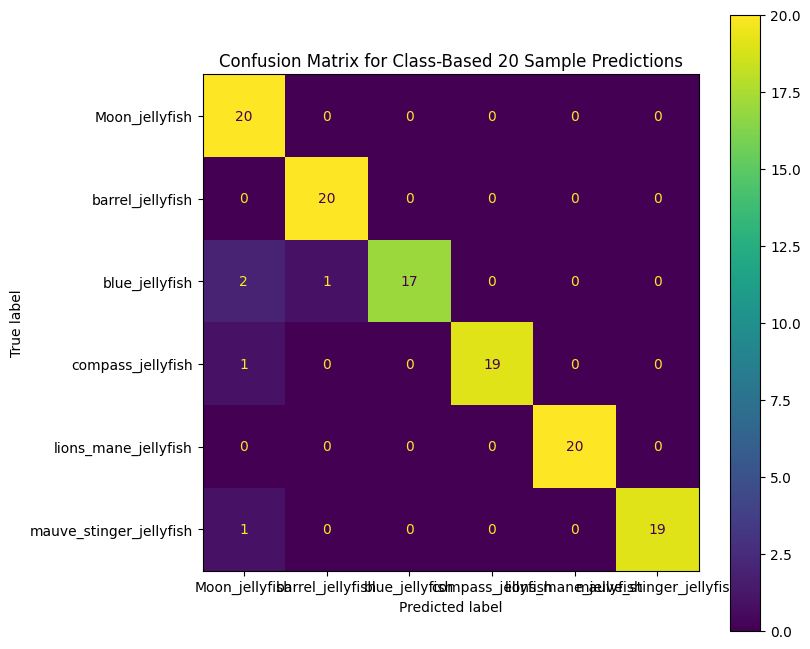

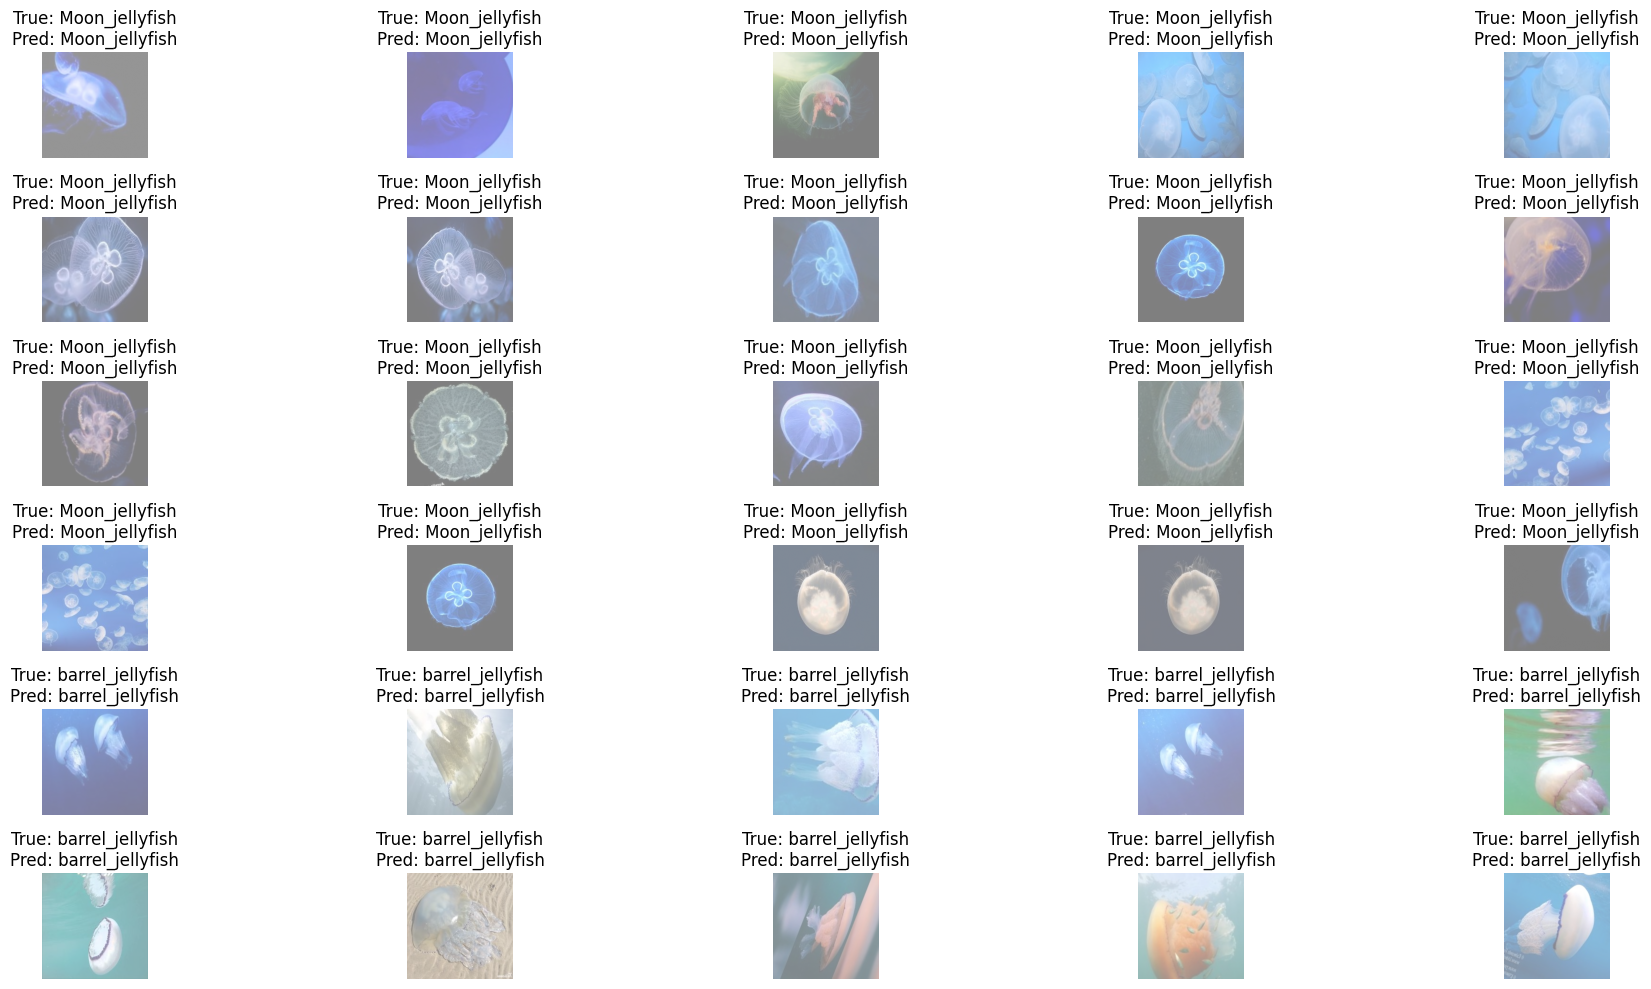

In [ ]:
# 종별 20장 샘플 선택 및 예측
def class_based_sample_and_predict(model, X_test_tensor, y_test_tensor, device, samples_per_class=20):
    unique_classes = torch.unique(y_test_tensor)
    X_sample_list = []
    y_sample_list = []
    indices_list = []

    for cls in unique_classes:
        # 해당 클래스의 모든 인덱스 가져오기
        class_indices = torch.where(y_test_tensor == cls)[0]
        # 해당 클래스에서 20장의 샘플 무작위 선택
        sampled_indices = random.sample(class_indices.tolist(), min(samples_per_class, len(class_indices)))
        indices_list.extend(sampled_indices)
        X_sample_list.append(X_test_tensor[sampled_indices])
        y_sample_list.append(y_test_tensor[sampled_indices])

    # 선택한 샘플 합치기
    X_sample = torch.cat(X_sample_list)
    y_sample = torch.cat(y_sample_list)

    # 모델을 사용하여 예측
    model.eval()
    with torch.no_grad():
        X_sample = X_sample.to(device)
        outputs = model(X_sample).logits
        _, y_pred = outputs.max(1)

    # 샘플의 실제 및 예측 레이블 반환
    return y_sample.cpu().numpy(), y_pred.cpu().numpy(), indices_list

# 종별 20장씩 예측
y_sample, y_pred, sample_indices = class_based_sample_and_predict(model, X_test_tensor, y_test_tensor, device)

# Confusion Matrix 생성
cm = confusion_matrix(y_sample, y_pred, labels=range(len(classes)))

# Confusion Matrix 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax)
plt.title("Confusion Matrix for Class-Based 20 Sample Predictions")
plt.show()

# 샘플 이미지와 예측 결과 시각화
plt.figure(figsize=(20, 10))

rows = len(classes)  # 클래스별 행
cols = 5  # 한 행에 5개씩 출력

# subplot이 초과되지 않도록 전체 subplot 크기 계산
total_subplots = rows * cols

# 이미지 출력
for i, idx in enumerate(sample_indices[:total_subplots]):  # 최대 subplot 수만큼 제한
    plt.subplot(rows, cols, i + 1)
    img = X_test_tensor[idx].cpu().numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
    img = (img * 0.5 + 0.5)  # Normalize 복원
    plt.imshow(img)
    plt.title(f"True: {classes[y_sample[i]]}\nPred: {classes[y_pred[i]]}")
    plt.axis("off")

plt.tight_layout()
plt.show()
